In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 2018
pdgId = 13
category = 0
version = "/vBDT/v2/"

if data_year == 2016:lumi = 35.92*1000 #in pb-1
elif data_year == 2017:lumi = 41.53 * 1000
else: lumi = 59.74 * 1000
data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data'+str(data_year)+version+'normalized/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/'+version+'normalized/'




if category == 0:
    fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
    fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'
    lumi = 31.34*1000


NEvents = {}

NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    NEvents_genweight[k] = root_dir['NEvents_genweight'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print("NEvents_genweight",NEvents_genweight[k])


    print ('weights',np.unique(a)*lumi)
    print(np.sum(a))
    print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)

data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data2018/vBDT/v2/normalized/Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root
NEvents 11494114.0
NEvents_genweight 0.0
weights [31340.]
4542.0
4542
mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18//vBDT/v2/normalized/ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root
NEvents 520800.0
NEvents_genweight 11183702.0
weights [-2.9535382  2.9240026  2.9535382]
3.4062502
36417
1.469191074371338


# Load trigger

In [3]:
trigger_names_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]
xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [4]:


# Imports
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import math
import pickle as pickle
import ROOT as root
import os
import shlex
import uproot
import seaborn as sns

variables = [
            ['cscRechitClusterXSpread', 'cscRechitClusterXSpread', '$\Delta x_{cluster}$', 600, 0, 120],
             ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', '$\Delta y_{cluster}$', 600, 0, 120],
#              ['cscRechitClusterZSpread', 'cscRechitClusterZSpread', '$\Delta z_{cluster}$', 600, 0, 120],
             ['cscRechitClusterNStation', 'cscRechitClusterNStation', 'N_{station}$', 5, 0, 5],

            ['cscRechitClusterEtaPhiSpread', 'cscCRechitlusterEtaPhiSpread', '$\Delta \eta\times\phi_{cluster}$', 100, -4, -4],
            ['cscRechitClusterX', 'cscRechitClusterX', '$x_{cluster}$', 1100, -1100, 1100],
            ['cscRechitClusterY', 'cscRechitClusterY', '$y_{cluster}$', 1100, -1100, 1100],
            ['cscRechitClusterZ', 'cscRechitClusterZ', '$z_{cluster}$', 1100, -1100, 1100],
            ]



variables = [
            
            ['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5],
            ['cscRechitClusterEtaSpread', 'cscRechitClusterEtaSpread', '$\eta$ spread', 50, 0, 0.3],
            ['cscRechitClusterPhiSpread', 'cscRechitClusterPhiSpread', '$\phi$ spread', 50, 0, 0.3],
            ['cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaPhiSpread', '$\eta-\phi$ spread', 50, 0, 0.2],
            ['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\phi$',25, 0, 3.2],
            ['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\eta$',  50, 0, 2.5],
            ['cscRechitClusterZ', 'cscRechitClusterZ', 'cluster Z [cm]', 30, 600, 1100],
            ]


# plot correlation with n_rechits

In [5]:
# Plotting ncsc
import scipy
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
T = tree_bkg['data']
for i, var in enumerate(variables):
#     evt_selection  = T.array('met') > 200
    nCscRechitClusters = T.array('nCscRechitClusters')
    cscRechits = T.array('cscRechitClusterSize')[nCscRechitClusters>0][:,0]
    variable_check = np.abs(T.array(var[0])[nCscRechitClusters>0][:,0])
    print(var[0],scipy.stats.pearsonr(cscRechits, variable_check))

#     h[k] = create_TH2D(np.column_stack((np.array(y_pred[y_test == 0]), np.array(cscRechitClusterSize[indices_test][y_test == 0]))), axis_title = ['BDT score','N_{rechits}','Events'], binning=[80,0,1,100,0,1500])
#     h[k] = h[k].ProfileX()
#     h[k].GetXaxis().SetLabelSize(0.04)

#     h[k].GetYaxis().SetTitle('N_{rechits}')
#     h[k].SetLineColor(std_color_list[0])
#     # leg.AddEntry(h[k], k)
#     #     h[k].SetMaximum(10E5)
#     #     h[k].SetMinimum(1)
#     h[k].Draw('colz')
# c.SetRightMargin(0.2)


# if setlog: 
# c.SetLogz()
# c.Draw()


cscRechitClusterNStation (-0.0031344160806593075, 0.8327434246510949)
cscRechitClusterEtaSpread (0.21810118397475842, 4.851059793053865e-50)
cscRechitClusterPhiSpread (0.23503750556656502, 4.76087575227347e-58)
cscRechitClusterEtaPhiSpread (0.16329921567276676, 1.62494757986926e-28)
cscRechitClusterPhi (0.015496522740724808, 0.296414380018803)
cscRechitClusterEta (-0.03969381724827446, 0.007462732773164594)
cscRechitClusterZ (-0.04178824602636896, 0.004851267211331754)


# event selection

In [6]:
df_signal = uproot.open(fpath_bkg['mc'])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)
df_bkg = uproot.open(fpath_bkg['data'])['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)

cscRechitClusterSize_signal = uproot.open(fpath_bkg['mc'])['MuonSystem'].pandas.df(['cscRechitClusterSize'], flatten=True)
cscRechitClusterSize_bkg = uproot.open(fpath_bkg['data'])['MuonSystem'].pandas.df(['cscRechitClusterSize'], flatten=True)
cscRechitClusterSize = np.concatenate([cscRechitClusterSize_bkg.values,cscRechitClusterSize_signal.values])

jetMet_dPhiMin_signal = uproot.open(fpath_bkg['mc'])['MuonSystem'].pandas.df(['jetMet_dPhiMin'], flatten=True)
jetMet_dPhiMin_bkg = uproot.open(fpath_bkg['data'])['MuonSystem'].pandas.df(['jetMet_dPhiMin'], flatten=True)
jetMet_dPhiMin = np.concatenate([jetMet_dPhiMin_bkg.values,jetMet_dPhiMin_signal.values])


print(cscRechitClusterSize.shape, jetMet_dPhiMin.shape)

print("Number of signal events: "+ str(len(df_signal)))
print("Number of background events: "+str(len(df_bkg)))
x = np.concatenate([df_bkg.values,df_signal.values])

x = np.hstack((x[:, :5], np.abs(x[:, 5:]))) ## change the last two variables to positive
#creating numpy array for target variables
y = np.concatenate([np.zeros(len(df_bkg)),
                        np.ones(len(df_signal))])
weight = np.concatenate([np.ones(len(df_bkg))*len(df_signal)/len(df_bkg),
                        np.ones(len(df_signal))])
print("Number of signal events: "+ str(len(df_signal)))
print("Number of background events: "+str(len(df_bkg)))
print('weights:',np.unique(weight), len(df_signal)/len(df_bkg))
indices = np.arange(len(y))

(41677, 1) (40959, 1)
Number of signal events: 37115
Number of background events: 4562
Number of signal events: 37115
Number of background events: 4562
weights: [1.        8.1356861] 8.135686102586584


0 0 0
['cscRechitClusterNStation', 'cscRechitClusterNStation', '$N_{station}$', 5, 0, 5]
1 0 1
['cscRechitClusterEtaSpread', 'cscRechitClusterEtaSpread', '$\\eta$ spread', 50, 0, 0.3]
2 0 2
['cscRechitClusterPhiSpread', 'cscRechitClusterPhiSpread', '$\\phi$ spread', 50, 0, 0.3]
3 1 0
['cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaPhiSpread', '$\\eta-\\phi$ spread', 50, 0, 0.2]
4 1 1
['cscRechitClusterPhi', 'cscRechitClusterPhi', 'cluster $\\phi$', 25, 0, 3.2]
5 1 2
['cscRechitClusterEta', 'cscRechitClusterEta', 'cluster $\\eta$', 50, 0, 2.5]
6 2 0
['cscRechitClusterZ', 'cscRechitClusterZ', 'cluster Z [cm]', 30, 600, 1100]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


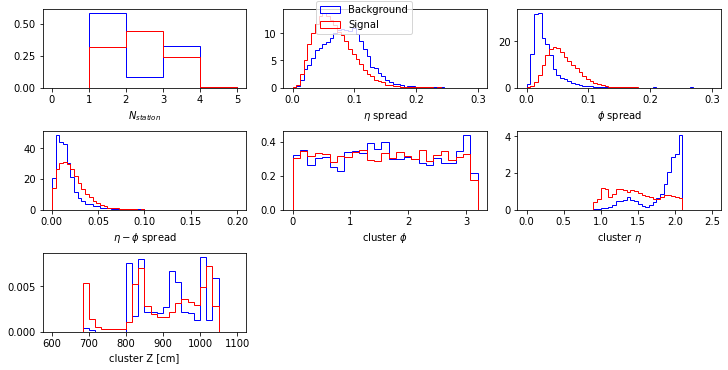

In [7]:

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
columns = 3
fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(10,5), constrained_layout=True)
# fig1, axs = plt.subplots(int(len(variables)/columns)+1, columns, figsize=(5,8), constrained_layout=True)


# for ax, case in zip(axs, cases):
#     ax.set_title('markevery=%s' % str(case))
trim_axs(axs, len(variables))

r = 0
c = 0
for i, var in enumerate(variables):
#     axs[i].hist(x[:,i][y==0])
    print(i,r,c)
    print(variables[i])
    bkg = axs[r,c].hist(x[:,i][y==0], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Background', color = 'b')
    sig = axs[r,c].hist(x[:,i][y==1], variables[i][3], (variables[i][4], variables[i][5]), density = True, histtype = 'step', label = 'Signal', color = 'r')
#     axs[r,c].legend()
    axs[r,c].set_xlabel(variables[i][2])
    if c == columns-1:
#         if r == 0:axs[r,c].legend(loc = 'upper right')
        c = 0
        r+=1
        
    else:c+=1
#     if i == len(variables)-1:
fig1.legend([bkg, sig],     # The line objects
           labels=['Background', 'Signal'],   # The labels for each line
           loc="upper center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           )
#     h['OOT_data'] = create_TH1D(x[:,i][y==0], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])
#     h['MC_signal'] = create_TH1D(x[:,i][y==1], axis_title = [variables[i][2],'Events'], binning=[variables[i][3], variables[i][4], variables[i][5]])



# train

In [7]:
# split data into train and test sets
seed = 7
test_size = 0.2
sample_size = 1.0
# x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices,train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)
x_train, x_test, y_train, y_test, indices_train, indices_test, weight_train, weight_test\
    = train_test_split(x, y,indices, weight, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

# fit model no training data
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=1, n_jobs=4, reg_lambda=1.0)
model.fit(x_train, y_train, sample_weight=weight_train)
# model.fit(x_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [250]:
# make predictions for test data
y_pred = model.predict_proba(x_test)[:, 1]
y_pred_train = model.predict_proba(x_train)[:, 1]
y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2'
# import pickle
# pickle.dump(model, open("bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p6_abs_EtaPhi_v2.pickle", "wb"))
#v2 has weight fixed

Accuracy: 95.03%


# load bdt

In [9]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]



# ROC curve

In [187]:

AUC = roc_auc_score(y_test, y_pred)
print("AUC: "+str(AUC))
#get roc curve
#roc = roc_curve(y_test, y_pred)
fpr, tpr, thr = roc_curve(y_test, y_pred)

AUC: 0.9783405376288716


## significance

In [188]:

significance = []
effSignal = []
effBkg = []
thresholds = []

ctr = 0
for i in range(len(fpr)):
    if fpr[i] > 1e-5 and tpr[i] > 1e-5:
#         print("thr = "+str(thr[i])+", fpr = "+str(fpr[i]) + ", tpr = "+str(tpr[i]))
        #print fpr[i], tpr[i] 
        #significance.append(math.sqrt(lumi)*4.8742592356*0.006431528796*tpr[i]/math.sqrt(fpr[i]*0.9935684712))
#         significance.append(*tpr[i]/math.sqrt(fpr[i]*bkgEvents))
        effSignal.append(tpr[i])
        effBkg.append(fpr[i])
        thresholds.append(thr[i])
        #print significance[ctr], ' ' , fpr[ctr], ' ', tpr[ctr]
        ctr = ctr + 1


# max_significance = max(significance)
# idx_max_significance = np.argmax(np.array(significance))
# best_threshold = thresholds[idx_max_significance]
# best_effSignal = effSignal[idx_max_significance]
# best_effBkg = effBkg[idx_max_significance]

# print("max_significance: "+str(max_significance))
# print("best_threshold: "+str(best_threshold))
# print("best_effSignal: "+str(best_effSignal))
# print("best_effBkg: "+str(best_effBkg))

idx_WP99 = 0
minD0p9 = 999.0
for idx in range(len(effSignal)):
    if abs(effSignal[idx] - 0.99) < minD0p9:
        idx_WP99 = idx
        minD0p9 = abs(effSignal[idx] - 0.99)

# WP90_significance = significance[idx_WP90]
WP99_threshold = thresholds[idx_WP99]
WP99_effSignal = effSignal[idx_WP99]
WP99_effBkg = effBkg[idx_WP99]

# print("WP90_significance: "+str(WP90_significance))
print("WP99_threshold: "+str(WP99_threshold))
print("WP99_effSignal: "+str(WP99_effSignal))
print("WP99_effBkg: "+str(WP99_effBkg))

idx_WP90 = 0
minD0p8 = 999.0
for idx in range(len(effSignal)):
        if abs(effSignal[idx] - 0.90) < minD0p8:
                idx_WP90 = idx
                minD0p8 = abs(effSignal[idx] - 0.90)

# WP80_significance = significance[idx_WP80]
WP90_threshold = thresholds[idx_WP90]
WP90_effSignal = effSignal[idx_WP90]
WP90_effBkg = effBkg[idx_WP90]

# print("WP80_significance: "+str(WP80_significance))
print("WP90_threshold: "+str(WP90_threshold))
print("WP90_effSignal: "+str(WP90_effSignal))
print("WP90_effBkg: "+str(WP90_effBkg))


WP99_threshold: 0.14595667
WP99_effSignal: 0.9900027019724399
WP99_effBkg: 0.2291220556745182
WP90_threshold: 0.7802247
WP90_effSignal: 0.9000270197243988
WP90_effBkg: 0.061027837259100645


# plot roc curve

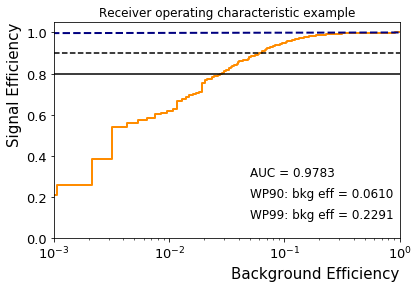

In [189]:

#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)
plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
plt.show()

# plot discrimination

0.002502564


Text(1.0, 1.01, '13 TeV')

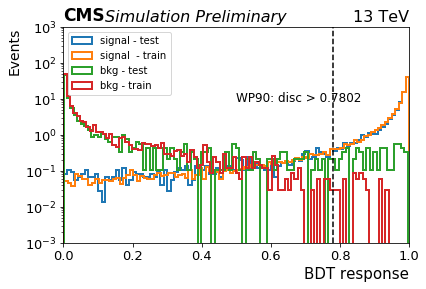

In [232]:
y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})

disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='signal - test')
plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='signal  - train')
plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='bkg - test')
plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype='step', lw=2, label='bkg - train')

print(np.min(disc_signal_train))
plt.yscale('log')
plt.xlim([0.0, 1.0])
plt.ylim([0.001, 1000.0])
plt.legend(loc='upper left')
plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(x=WP90_threshold, color='black', linestyle='--')
# plt.axvline(x=WP99_threshold, color='black')
plt.text(0.5,0.7,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
# plt.text(0.5,0.6,‘WP80: disc > %.4f’%WP80_threshold, fontsize=12, horizontalalignment=‘center’, verticalalignment=‘center’, transform=plt.gca().transAxes)
plt.text(0.0, 1.01, 'CMS', ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, 'Simulation Preliminary', ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, '13 TeV', ha='right', va='bottom', transform=ax.transAxes, fontsize=16)

# # f = plt.figure()
# ax = f.add_subplot(111)
# plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# # plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype=“step”, lw=2, label=“WWZ - test”)
# # plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype=“step”, lw=2, label=“WWZ  - train”)
# # plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype=“step”, lw=2, label=“ttZ - test”)
# # plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype=“step”, lw=2, label=“ttZ - train”)
# # plt.yscale(“linear”)
# # plt.xlim([0.0, 1.0])
# # #plt.ylim([0.001, 100.0])
# # plt.legend(loc=“upper center”)
# # plt.xlabel(‘BDT response’,horizontalalignment=‘right’, x=1.0, fontsize=15)
# # plt.ylabel(‘Events’,horizontalalignment=‘right’, y=1.0, fontsize=14)
# # plt.xticks(fontsize=13)
# # plt.yticks(fontsize=13)
# # plt.axvline(x=WP90_threshold, color=“black”, linestyle=‘--’)
# # plt.axvline(x=WP80_threshold, color=“black”)
# # plt.text(0.5,0.7,‘WP90: disc > %.4f’%WP90_threshold, fontsize=12, horizontalalignment=‘center’, verticalalignment=‘center’, transform=plt.gca().transAxes)
# # plt.text(0.5,0.6,‘WP80: disc > %.4f’%WP80_threshold, fontsize=12, horizontalalignment=‘center’, verticalalignment=‘center’, transform=plt.gca().transAxes)
# # plt.text(0.0, 1.01, “CMS”, ha=‘left’, va=‘bottom’, transform=ax.transAxes, weight=‘bold’, fontsize=17)
# # plt.text(0.12, 1.01, “Simulation Preliminary”, ha=‘left’, va=‘bottom’, transform=ax.transAxes, style=‘italic’, fontsize=16)
# # plt.text(1.0, 1.01, “13 TeV”, ha=‘right’, va=‘bottom’, transform=ax.transAxes, fontsize=16)


# bdt efficiency

In [251]:
import scipy
import os

# print(np.array(y_pred[y_test == 0]))
# print(np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten())
# print(scipy.stats.pearsonr(bdt_score[k], cscClusterSize[k]))
# print(scipy.stats.pearsonr(bdt_score[k], jetMet_dPhiMin30[k]))

# wp90 =  0.9598022
wp90 =  0.7802247
outDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/bdt_eff/'
if not os.path.isdir(outDir): print("OUTPUT DIR DOESN'T EXIST")
text_file = open(outDir+bdt_name+".txt", "w")

y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})

disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values


ncsc = cscRechitClusterSize[indices_test][y_test==0]
print(len(ncsc), len(disc_bkg))
print(np.count_nonzero(disc_bkg>wp90)/len(disc_bkg))
for n_rechit in np.arange(50,300,10):
    cond1 = ncsc > n_rechit
    cond1 = cond1[:,0]
    cond2 =  disc_bkg > wp90
    cond_gt = np.logical_and(cond1, cond2)
    cond_lt = np.logical_and(np.logical_not(cond1), cond2)
#     print(cond1.shape, cond2.shape)
#     print(np.count_nonzero(cond1), np.count_nonzero(cond2), np.count_nonzero(cond_gt), np.count_nonzero(cond_lt))
    eff_low = np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1))
    eff_high = np.count_nonzero(cond_gt)/np.count_nonzero(cond1)
    eff_total = np.count_nonzero(cond2)/len(cond2)
    assert(np.count_nonzero(cond_lt)+np.count_nonzero(cond_gt) == np.count_nonzero(cond2))
    print(n_rechit, eff_total,eff_low , eff_high)
    
    text_file.write('{0}, {1}, {2} \n'.format(n_rechit, eff_low , eff_high))

    

# for dphi in [0.0, 0.6, 1, 1.5, 2, 2.5]:
#     cond1 = jetMet_dPhiMin30[k] >= dphi
#     cond2 = bdt_score[k] > wp90
#     cond_gt = np.logical_and(cond1, cond2)
#     cond_lt = np.logical_and(np.logical_not(cond1), cond2)
#     print(dphi, np.count_nonzero(cond_gt)/np.count_nonzero(cond1))

    
text_file.close()

    

934 934
0.061027837259100645
50 0.061027837259100645 0.0136986301369863 0.06504065040650407
60 0.061027837259100645 0.03734439834024896 0.08628318584070796
70 0.061027837259100645 0.041176470588235294 0.1141732283464567
80 0.061027837259100645 0.043593130779392336 0.13559322033898305
90 0.061027837259100645 0.046511627906976744 0.1623931623931624
100 0.061027837259100645 0.051008303677342826 0.15384615384615385
110 0.061027837259100645 0.05439814814814815 0.14285714285714285
120 0.061027837259100645 0.0552423900789177 0.1702127659574468
130 0.061027837259100645 0.05679287305122494 0.16666666666666666
140 0.061027837259100645 0.05849889624724062 0.14285714285714285
150 0.061027837259100645 0.05805038335158817 0.19047619047619047
160 0.061027837259100645 0.05767138193688792 0.26666666666666666
170 0.061027837259100645 0.057483731019522775 0.3333333333333333
180 0.061027837259100645 0.05735930735930736 0.4
190 0.061027837259100645 0.058315334773218146 0.375
200 0.061027837259100645 0.0582

# plot feature importances

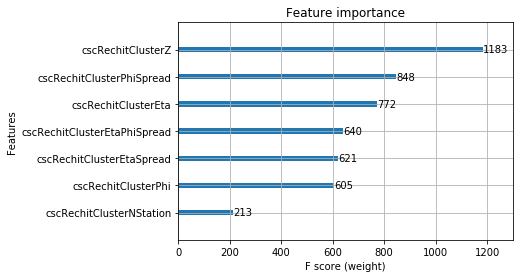

In [57]:
#plot feature importances

model.get_booster().feature_names = [row[1] for row in variables]

xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
# plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.pdf', bbox_inches='tight')
# plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.png', bbox_inches='tight')
# plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + '.eps', bbox_inches='tight')
# os.system("chmod 755 "+plotDir+"training/*")

#xgb.plot_tree( model.get_booster() )
# xgb.plot_tree( model )
# fig = plt.gcf()
#fig.set_size_inches(500, 50)
plt.draw()
# plt.savefig(plotDir+'training/myTree_' + test_name + '.pdf')
# plt.savefig(plotDir+'training/myTree_' + test_name + '.png')
# plt.savefig(plotDir+'training/myTree_' + test_name + '.eps')
# os.system("chmod 755 "+plotDir+"training/*")

# compare two ROC curves

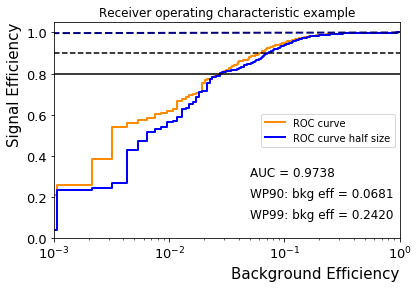

In [52]:

import pickle
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2.pickle', "rb" ))
model2 = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p6_abs_EtaPhi_v2.pickle', "rb" ))

y_pred = model.predict_proba(x_test)[:, 1]
y_pred2 = model2.predict_proba(x_test)[:, 1]


fpr, tpr, thr = roc_curve(y_test, y_pred)
fpr2, tpr2, thr2 = roc_curve(y_test, y_pred2)

#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='ROC curve half size')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([10E-4, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xscale('log')
plt.axhline(y=0.9, color="black", linestyle='--')
plt.axhline(y=0.8, color="black")
plt.text(0.05,0.1,'WP99: bkg eff = %.4f'%WP99_effBkg, fontsize=12)
plt.text(0.05,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
plt.text(0.05,0.3,'AUC = %.4f'%AUC, fontsize=12)
plt.title('Receiver operating characteristic example')
plt.legend(loc="center right")
plt.show()

# correlation with csc rechit size

(25007, 1)
(25007,)


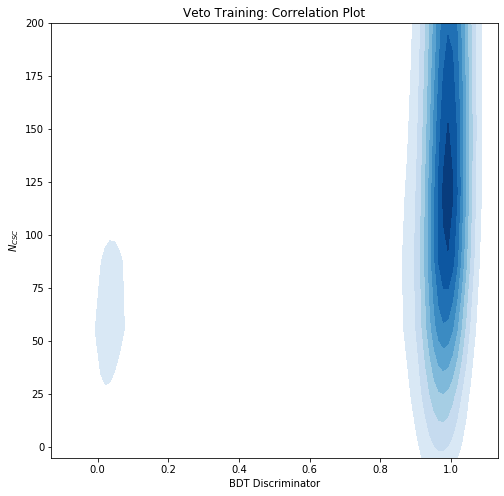

In [39]:
f_heat, ax = plt.subplots(figsize=(8, 8))
# ax = sns.kdeplot(np.array(ncsc_signal)[:,0], np.array(disc_signal_old), cmap="Reds", shade=True, shade_lowest=False)
print(cscRechitClusterSize[indices_test].shape)
print(y_pred.shape)
ax = sns.kdeplot(np.array(y_pred), np.array(cscRechitClusterSize[indices_test]),
                 cmap="Blues", shade=True, shade_lowest=False)
# ax = sns.kdeplot(np.array(ncsc_bkg)[:,0], np.array(disc_bkg_normal),
#                  cmap="Reds", shade=False, shade_lowest=False)
# ax = plt.scatter(np.array(ncsc_signal)[:,0], np.array(disc_signal_old), alpha=0.5)
# ax = sns.kdeplot(np.array(ncsc_signal)[:,0], disc_signal_in,
#                  cmap="Greens", shade=True, shade_lowest=False)
plt.ylim(-5, 200)
plt.xlabel('BDT Discriminator')
plt.ylabel('$N_{CSC}$')
plt.title('Veto Training: Correlation Plot')

# Add labels to the plot0.0011161413
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
# green = sns.color_palette("Greens")[-2]
# ax.text(2.5, 8.2, "No Vetoes", size=16, color=blue)
# ax.text(3.8, 4.5, "Trained on Vetoes", size=16, color=red)
# ax.text(2.0, 7, "Trained on Vetoes: In-time", size=16, color=green)

In [70]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


# h[k] = create_TH2D(np.column_stack((np.array(y_pred[y_test == 0]), np.array(cscRechitClusterSize[indices_test][y_test == 0]))),\
#                    axis_title = ['BDT score','N_{rechits}','Events'], binning=[50,0,1,50,0,600])

# h[k] = h[k].ProfileX()
h[k].GetXaxis().SetLabelSize(0.04)

h[k].GetYaxis().SetTitle('N_{rechits}')

# r = h[k].Fit('pol1', 'LRSQ+', '', 50,400)
# print(r.Get())
# print(r.Prob())
# h[k].GetFunction("pol1").SetLineColor(std_color_list[2])
# h[k].GetFunction("pol1").SetLineWidth(2)


h[k].SetLineColor(std_color_list[0])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)


# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)


(40959, 1) (8336,)


IndexError: index 41605 is out of bounds for axis 0 with size 40959

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [210]:
np.arange(50,300,10)

array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290])

In [60]:
import scipy
# print(np.array(y_pred[y_test == 0]))
# print(np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten())
print(scipy.stats.pearsonr(np.array(y_pred[y_test == 0]), np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten()))

# wp90 =  0.9598022
wp90 =  0.7802
# WP90_effBkg: 0.06531049250535331
for n_rechit in np.arange(50,300,10):
    cond1 = cscRechitClusterSize[indices_test][y_test == 0]> n_rechit
    cond2 = y_pred[y_test == 0] > wp90
    cond = np.logical_and(cond1[:,0], cond2)
#     print(np.count_nonzero(cond1))
#     print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1))
#     print( str(n_rechit), np.count_nonzero(cond1), np.count_nonzero(cond)/np.count_nonzero(cond1))
    print( str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1))

    cond1 = cscRechitClusterSize[indices_test][y_test == 0] < n_rechit
    cond2 = y_pred[y_test == 0] > wp90
    cond = np.logical_and(cond1[:,0], cond2)
    print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1[:,0]))


(0.18520134155398751, 1.1852770985547027e-08)
50 0.06504065040650407
n_rechits 50 0.0
60 0.08628318584070796
n_rechits 60 0.035164835164835165
70 0.1141732283464567
n_rechits 70 0.04054054054054054
80 0.13559322033898305
n_rechits 80 0.0425531914893617
90 0.1623931623931624
n_rechits 90 0.04668304668304668
100 0.15384615384615385
n_rechits 100 0.04994054696789536
110 0.14285714285714285
n_rechits 110 0.05439814814814815
120 0.1702127659574468
n_rechits 120 0.0552423900789177
130 0.16666666666666666
n_rechits 130 0.05679287305122494
140 0.14285714285714285
n_rechits 140 0.05849889624724062
150 0.19047619047619047
n_rechits 150 0.05805038335158817
160 0.26666666666666666
n_rechits 160 0.05767138193688792
170 0.3333333333333333
n_rechits 170 0.057483731019522775
180 0.4
n_rechits 180 0.05735930735930736
190 0.375
n_rechits 190 0.058315334773218146
200 0.42857142857142855
n_rechits 200 0.05825242718446602
210 0.5
n_rechits 210 0.05818965517241379
220 0.5
n_rechits 220 0.05818965517241379
2

# Correlation with delta phi

In [79]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

In [118]:
%%time

gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}

jetMet_dPhi = {}
jetMet_dPhiMin = {}
jetMet_dPhiMin4 = {}
jetMet_dPhiMin4_50 = {}

cscClusterSize = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}

cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
dphiMet_cluster = {}
bdt_score = {}
# make predictions for test data

import pickle
model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]



T = tree_bkg['data']
 
##### bdt variables ####
sel_ev = T.array('nCscRechitClusters') > 0
cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_ev][:,0].flatten()
cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_ev][:,0].flatten()
cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_ev][:,0].flatten()
cscRechitClusterEtaSpread[k] = T.array('cscRechitClusterEtaSpread')[sel_ev][:,0].flatten()
cscRechitClusterPhiSpread[k] = T.array('cscRechitClusterPhiSpread')[sel_ev][:,0].flatten()
cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_ev][:,0].flatten()
cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_ev][:,0].flatten()
cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_ev][:,0].flatten()
cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_ev][:,0].flatten()
cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_ev][:,0].flatten()
cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_ev][:,0].flatten()
cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_ev][:,0].flatten()

# if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':

#     bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#      'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#      'cscRechitClusterNStation':cscRechitClusterNStation[k],
#      'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#      'cscRechitClusterX':cscRechitClusterX[k],
#      'cscRechitClusterY':cscRechitClusterY[k],
#      'cscRechitClusterZ':cscRechitClusterZ[k],
#     }
# elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
   
# else:
#     print('BDT NAME NOT FOUND')
bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
'cscRechitClusterPhi':cscRechitClusterPhi[k],
'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
}

dataset = pd.DataFrame(bdt_var)
bdt_score[k] = model.predict_proba(dataset.values)[:, 1]

# dphiMet_cluster[k] = np.abs(T.array('cscRechitClusterMet_dPhi'))[sel_ev][:,0].flatten()[bdt_sel]
metPhi[k] = T.array('metPhi')[sel_ev]
jetPhi[k] = T.array('jetPhi')[sel_ev]
jetPt[k] = T.array('jetPt')[sel_ev]
jetMet_dPhiMin30[k] = []
for ev in range(len(jetPhi[k])):
    dphi_min_temp = 999
    for i in range(len(jetPhi[k][ev])):
        if jetPt[k][ev][i] < 30: continue
        dphi_temp = abs(deltaPhi(metPhi[k][ev],jetPhi[k][ev][i]))
        if dphi_min_temp > dphi_temp: dphi_min_temp = dphi_temp
    jetMet_dPhiMin30[k].append(dphi_min_temp)
jetMet_dPhiMin30[k] = np.array(jetMet_dPhiMin30[k])


cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_ev][:,0].flatten()
print(len(cscClusterSize[k]), len(bdt_score[k]))

4542 4542
CPU times: user 536 ms, sys: 12 ms, total: 548 ms
Wall time: 447 ms


[3.3074658e-04 1.0181189e-02 1.5174421e-02 ... 6.7871541e-01 1.6649809e-02
 4.7072092e-01]
0.0025866031646728516


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


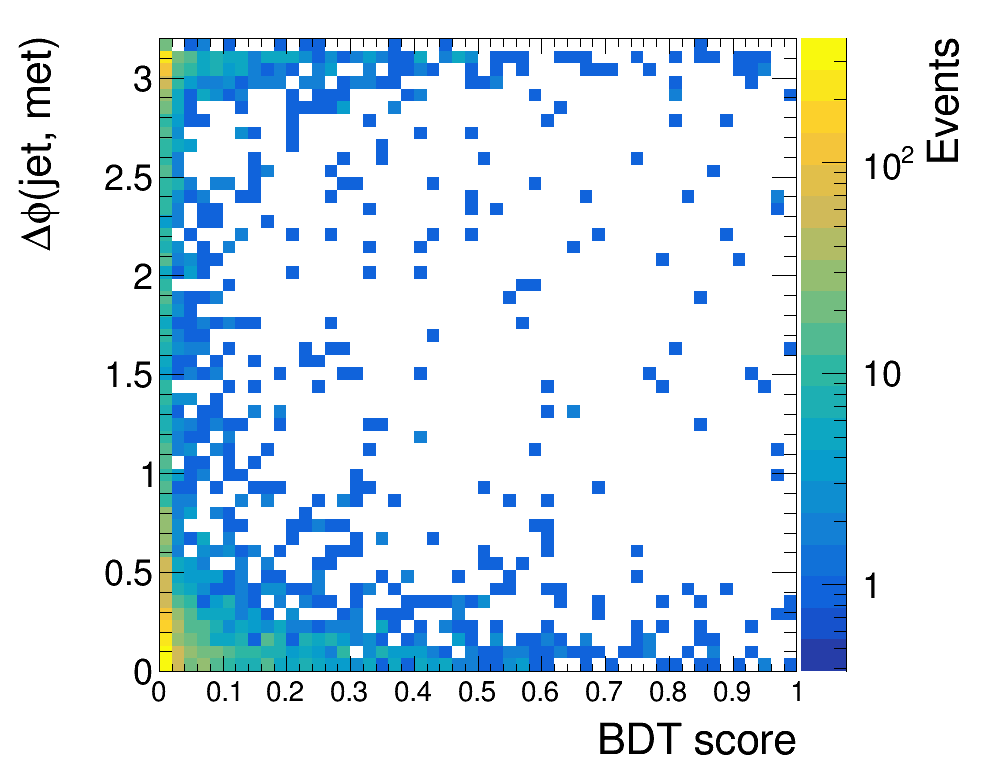

In [119]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
print(bdt_score[k])
# print(cscClusterSize[k].flatten())
# h[k] = create_TH2D(np.column_stack((bdt_score[k], cscClusterSize[k])), axis_title = ['BDT score','N_{rechits}','Events'], binning=[50,0,1,50,0,600])
h[k] = create_TH2D(np.column_stack((bdt_score[k], jetMet_dPhiMin30[k])), axis_title = ['BDT score','#Delta#phi(jet, met)','Events'], binning=[50,0,1,50,0,3.2])

# h[k] = h[k].ProfileX()
h[k].GetXaxis().SetLabelSize(0.04)

h[k].SetLineColor(std_color_list[0])
h[k].Draw('colz')
c.SetRightMargin(0.2)


# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)


In [137]:
import scipy
# print(np.array(y_pred[y_test == 0]))
# print(np.array(cscRechitClusterSize[indices_test][y_test == 0]).flatten())
print(scipy.stats.pearsonr(bdt_score[k], cscClusterSize[k]))
print(scipy.stats.pearsonr(bdt_score[k], jetMet_dPhiMin30[k]))

# wp90 =  0.9598022
wp90 =  0.7802247
outDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/'
fileName = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2'
text_file = open(outDir+fileName+".txt", "w")
print(np.count_nonzero(bdt_score[k]>wp90)/len(bdt_score[k]))
# for n_rechit in np.arange(50,300,10):
#     cond1 = cscClusterSize[k]> n_rechit
#     cond2 =  bdt_score[k] > wp90
#     cond_gt = np.logical_and(cond1, cond2)
#     cond_lt = np.logical_and(np.logical_not(cond1), cond2)
#     print(n_rechit, np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond_gt)/np.count_nonzero(cond1))
    
#     text_file.write('{0}, {1}, {2} \n'.format(n_rechit, np.count_nonzero(cond_lt)/np.count_nonzero(cond1), np.count_nonzero(cond_gt)/np.count_nonzero(cond1)))

    

for dphi in [0.0, 0.6, 1, 1.5, 2, 2.5]:
    cond1 = jetMet_dPhiMin30[k] >= dphi
    cond2 = bdt_score[k] > wp90
    cond_gt = np.logical_and(cond1, cond2)
    cond_lt = np.logical_and(np.logical_not(cond1), cond2)
#     print(np.count_nonzero(cond1))
#     print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1))
#     print( str(n_rechit), np.count_nonzero(cond1), np.count_nonzero(cond)/np.count_nonzero(cond1))
#     print( str(dphi), np.count_nonzero(cond)/np.count_nonzero(cond1))
#     print(len(cond1), np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond1))
#     print(dphi, np.count_nonzero(cond_lt)/np.count_nonzero(np.logical_not(cond1)), np.count_nonzero(cond_gt)/np.count_nonzero(cond1))
    print(dphi, np.count_nonzero(cond_gt)/np.count_nonzero(cond1))

#     cond1 = jetMet_dPhiMin30[k] < dphi
#     cond2 = bdt_score[k] > wp90
#     cond = np.logical_and(cond1[:,0], cond2)
#     print("n_rechits", str(n_rechit), np.count_nonzero(cond)/np.count_nonzero(cond1[:,0]))

    
text_file.close()

    

(0.10037037162000934, 1.2045821838118213e-11)
(0.030699242273632316, 0.03855791530022282)
0.015852047556142668
0.0 0.015852047556142668
0.6 0.022781205505457997
1 0.02486772486772487
1.5 0.02476958525345622
2 0.024163568773234202
2.5 0.02193283070596299


# event yield vs. ncsc

# significance